In [21]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact

In [4]:
# Define the folder path for .csv files with summary of TTA among BGCs for each genera and concatenate them
folder_path = "/results/TTA_BGC"

# List all CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith(".csv")]

# Initialize an empty list to store dataframes
dataframes = []

# Iterate through each file, read it, and process
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    # Read the CSV file into a dataframe
    df = pd.read_csv(file_path)
    # Extract the genus from the filename (last part before extension, split by '_')
    genus = file.split('_')[-1].split('.')[0]
    # Add a 'Genus' column
    df['Genus'] = genus
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all dataframes
concatenated_df = pd.concat(dataframes, ignore_index=True)

In [5]:
concatenated_df.drop('Unnamed: 0', axis = 1, inplace = True)

In [6]:
concatenated_df.columns

Index(['Locus_ID', 'CDS_Product', 'Gene_Kind', 'Is_Core_Gene', 'Region_Nr',
       'Strain', 'Cand_Cluster_1', 'Cluster_Product_1', 'Product', 'Location',
       'UUA Codon Position', 'Relative_Position', 'Gene_Length',
       'UUA Codon Count', 'Start_Codon', 'Stop_Codon', 'Strand', 'Sequence',
       'Organism', 'GCF_ID', 'Genus'],
      dtype='object')

In [7]:
columns_to_keep = ['Locus_ID', 'CDS_Product', 'Gene_Kind', 'Region_Nr',
       'Strain', 'Cand_Cluster_1', 'Cluster_Product_1', 'Product', 
       'UUA Codon Position', 'Relative_Position',
       'UUA Codon Count','Organism', 'GCF_ID', 'Genus']

In [8]:
summary_df = concatenated_df[columns_to_keep]

In [9]:
summary_df = summary_df.fillna(0)

In [26]:
summary_df.head()

,Locus_ID,CDS_Product,Gene_Kind,Region_Nr,Strain,Cand_Cluster_1,Cluster_Product_1,Product,UUA Codon Position,Relative_Position,UUA Codon Count,Organism,GCF_ID,Genus
0,ABZ754_RS16045,aspartate 1-decarboxylase,unknown,1,GCF_040642575.1,1.0,T3PKS,0,0.0,0.0,0.0,0,0,Micromonospora
1,ABZ754_RS16050,septum formation family protein,unknown,1,GCF_040642575.1,1.0,T3PKS,0,0.0,0.0,0.0,0,0,Micromonospora
2,ABZ754_RS16055,L-aspartate oxidase,biosynthetic-additional,1,GCF_040642575.1,1.0,T3PKS,0,0.0,0.0,0.0,0,0,Micromonospora
3,ABZ754_RS16060,carboxylating nicotinate-nucleotide diphosphor...,unknown,1,GCF_040642575.1,1.0,T3PKS,0,0.0,0.0,0.0,0,0,Micromonospora
4,ABZ754_RS16065,type III pantothenate kinase,unknown,1,GCF_040642575.1,1.0,T3PKS,0,0.0,0.0,0.0,0,0,Micromonospora


In [11]:
def enrichment_per_strain(df, codon_col="UUA Codon Count", threshold=1.0):
    key_cols = ["Strain", "Genus"]  # ignore GCF_ID

    # mark codon presence
    df = df.copy()
    df["codon_present"] = df[codon_col].fillna(0) >= threshold
    df["codon_present"] = df["codon_present"].astype(int)

    # total genes per strain × kind
    totals = (
        df.groupby(key_cols + ["Gene_Kind"])
          .size()
          .rename("n_genes")
          .reset_index()
    )

    # codon+ genes per strain × kind
    positives = (
        df.groupby(key_cols + ["Gene_Kind"])["codon_present"]
          .sum()
          .rename("n_codon+")
          .reset_index()
    )

    # merge
    merged = pd.merge(totals, positives, on=key_cols + ["Gene_Kind"], how="outer").fillna(0)
    merged["n_genes"] = merged["n_genes"].astype(int)
    merged["n_codon+"] = merged["n_codon+"].astype(int)
    merged["n_codon-"] = merged["n_genes"] - merged["n_codon+"]

    results = []
    for keys, sub in merged.groupby(key_cols):
        strain, genus = keys
        total_pos = int(sub["n_codon+"].sum())
        total_neg = int(sub["n_codon-"].sum())

        for _, row in sub.iterrows():
            kind = row["Gene_Kind"]
            pos, neg = int(row["n_codon+"]), int(row["n_codon-"])
            bg_pos = total_pos - pos
            bg_neg = total_neg - neg

            if row["n_genes"] == 0 or (bg_pos + bg_neg == 0):
                continue

            odds, pval = fisher_exact([[pos, neg], [bg_pos, bg_neg]])

            results.append({
                "Strain": strain,
                "Genus": genus,
                "Gene_Kind": kind,
                "Codon_Col": codon_col,
                "Odds": odds,
                "pval": pval,
                "n_genes": int(row["n_genes"]),
                "n_codon+": pos,
                "frac_codon": pos / row["n_genes"] if row["n_genes"] > 0 else 0
            })

    return pd.DataFrame(results)

# --- Run it ---
results_TTA = enrichment_per_strain(summary_df, codon_col="UUA Codon Count", threshold=1.0)


In [29]:
results_TTA.head()

,Strain,Genus,Gene_Kind,Codon_Col,Odds,pval,n_genes,n_codon+,frac_codon,is_enriched
0,GCF_000009765.2,Streptomyces,biosynthetic,UUA Codon Count,2.978018,0.012281,83,8,0.096386,True
1,GCF_000009765.2,Streptomyces,biosynthetic-additional,UUA Codon Count,0.904404,0.860405,276,10,0.036232,False
2,GCF_000009765.2,Streptomyces,other,UUA Codon Count,0.000000,0.635981,33,0,0.000000,False
3,GCF_000009765.2,Streptomyces,regulatory,UUA Codon Count,2.367105,0.074050,87,7,0.080460,False
4,GCF_000009765.2,Streptomyces,transport,UUA Codon Count,1.324775,0.546916,80,4,0.050000,False


In [13]:
summary_global = (
    results_TTA
    .groupby("Gene_Kind")
    .agg(
        median_odds=("Odds", "median"),
        mean_odds=("Odds", "mean"),
        sig_frac=("pval", lambda x: (x < 0.05).mean()),
        mean_frac_codon=("frac_codon", "mean"),
        n_strains=("Strain", "nunique")
    )
    .reset_index()
)


In [14]:
summary_global

,Gene_Kind,median_odds,mean_odds,sig_frac,mean_frac_codon,n_strains
0,biosynthetic,2.154199,2.376103,0.358471,0.104631,1936
1,biosynthetic-additional,0.706038,0.775813,0.095558,0.042991,1936
2,other,1.102911,1.642813,0.081654,0.065209,1935
3,regulatory,1.996294,2.350671,0.314050,0.083648,1936
4,resistance,0.000000,inf,0.021696,0.040927,507
5,transport,0.784482,inf,0.022211,0.045858,1936
6,unknown,0.701549,inf,0.184401,0.043042,1936


In [15]:
summary_genus = (
    results_TTA
    .groupby(["Genus", "Gene_Kind"])
    .agg(
        median_odds=("Odds", "median"),
        mean_odds=("Odds", "mean"),
        sig_frac=("pval", lambda x: (x < 0.05).mean()),
        mean_frac_codon=("frac_codon", "mean"),
        n_strains=("Strain", "nunique")
    )
    .reset_index()
)

In [28]:
summary_genus.head()

,Genus,Gene_Kind,median_odds,mean_odds,sig_frac,mean_frac_codon,n_strains
0,Actinokineospora,biosynthetic,4.103581,3.453085,0.636364,0.215093,11
1,Actinokineospora,biosynthetic-additional,0.818519,0.771759,0.181818,0.070900,11
2,Actinokineospora,other,0.706536,0.722708,0.090909,0.058694,11
3,Actinokineospora,regulatory,1.278098,1.557229,0.272727,0.108294,11
4,Actinokineospora,resistance,0.000000,0.000000,0.000000,0.000000,6


In [17]:
# Add a column for enrichment: significant + odds > 1
results_TTA["is_enriched"] = (results_TTA["pval"] < 0.05) & (results_TTA["Odds"] > 1)

# Count per genus × kind
summary_genus_pct = (
    results_TTA.groupby(["Genus", "Gene_Kind"])
    .agg(
        n_strains=("Strain", "nunique"),
        n_enriched=("is_enriched", "sum")
    )
    .reset_index()
)

summary_genus_pct["pct_enriched"] = (
    summary_genus_pct["n_enriched"] / summary_genus_pct["n_strains"] * 100
)


In [27]:
summary_genus_pct.head(5)

,Genus,Gene_Kind,n_strains,n_enriched,pct_enriched
0,Actinokineospora,biosynthetic,11,7,63.636364
1,Actinokineospora,biosynthetic-additional,11,0,0.000000
2,Actinokineospora,other,11,0,0.000000
3,Actinokineospora,regulatory,11,3,27.272727
4,Actinokineospora,resistance,6,0,0.000000


In [19]:
# optional: fix the order of categories
kind_order = ["biosynthetic", "biosynthetic-additional", "regulatory",
              "resistance", "transport", "unknown", "other"]

# order genera by number of strains
genus_order = (summary_genus_pct.groupby("Genus")["n_strains"]
               .sum().sort_values(ascending=False).index.tolist())

# pivot to wide format: Genus x Gene_Kind
heat = (summary_genus_pct
        .assign(Gene_Kind=pd.Categorical(summary_genus_pct["Gene_Kind"],
                                         categories=kind_order, ordered=True))
        .pivot_table(index="Genus", columns="Gene_Kind", values="pct_enriched")
        .reindex(index=genus_order, columns=kind_order))

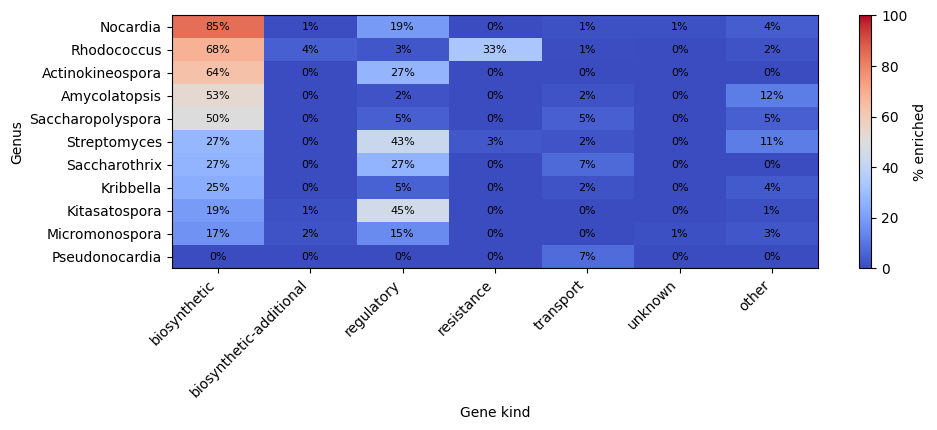

In [22]:
# --- order genera by biosynthetic enrichment ---
heat_sorted = heat.sort_values("biosynthetic", ascending=False)

fig, ax = plt.subplots(figsize=(10, max(4, 0.4*len(heat_sorted))))
im = ax.imshow(heat_sorted.values, aspect="auto", cmap="coolwarm", vmin=0, vmax=100)

# axes
ax.set_xticks(range(len(heat_sorted.columns)))
ax.set_xticklabels(heat_sorted.columns, rotation=45, ha="right")
ax.set_yticks(range(len(heat_sorted.index)))
ax.set_yticklabels(heat_sorted.index)
ax.set_xlabel("Gene kind")
ax.set_ylabel("Genus")

# annotate cells (optional)
for i in range(heat_sorted.shape[0]):
    for j in range(heat_sorted.shape[1]):
        val = heat_sorted.values[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.0f}%", ha="center", va="center", fontsize=8, color="black")

# colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("% enriched")

plt.tight_layout()
plt.savefig('/results/fig_pct_enriched_heatmap_TTA_sorted.png', dpi=300)
plt.show()

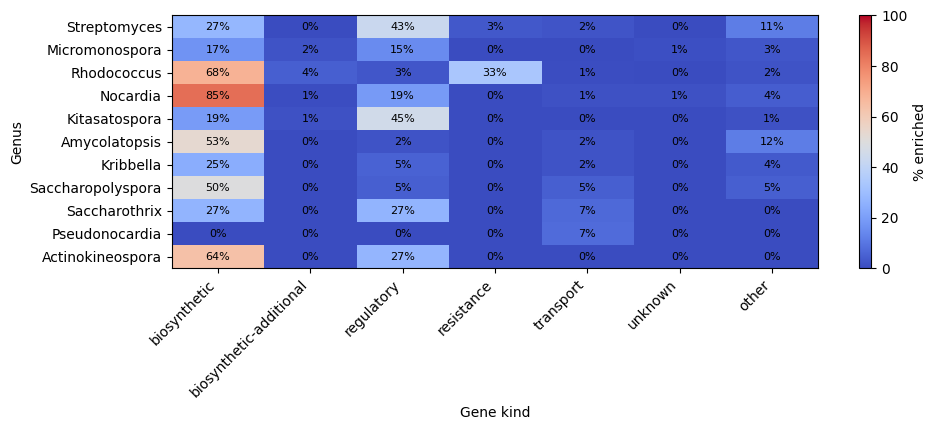

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# using your "heat" DataFrame from earlier (Genus × Gene_Kind with pct_enriched values)

fig, ax = plt.subplots(figsize=(10, max(4, 0.4*len(heat))))
# use a diverging colormap, center at 50
im = ax.imshow(heat.values, aspect="auto", cmap="coolwarm", vmin=0, vmax=100)

# axes
ax.set_xticks(range(len(heat.columns)))
ax.set_xticklabels(heat.columns, rotation=45, ha="right")
ax.set_yticks(range(len(heat.index)))
ax.set_yticklabels(heat.index)
ax.set_xlabel("Gene kind")
ax.set_ylabel("Genus")
#ax.set_title("% of strains enriched")

# annotate cells (optional)
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        val = heat.values[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.0f}%", ha="center", va="center", fontsize=8, color="black")

# colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("% enriched")

plt.tight_layout()
plt.savefig('/results/fig_pct_enriched_heatmap_TTA.png', dpi=300)
plt.show()

